In [3]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../..')
import torch, torcwa
import os
from os.path import join
import numpy as np
from matplotlib import pyplot as plt

from utils.paths import *
from utils import utils
from evaluation.diffraction_measurement import torcwa_simulation
from data.data_config import get_data_cfg
from evaluation.metrics import *
from torch.utils.data import DataLoader

In [48]:
import numpy as np
import torch
from scipy.ndimage import distance_transform_edt, maximum_filter

def critical_size(mask: np.ndarray):
    """
    Minimal feature size (pixels) across all directions for a binary image.
    Returns (size, where, phase) where phase=1 means foreground bottleneck
    and phase=0 means background bottleneck.
    """
    m = (mask > 0)

    def phase_min_width(phase_bool):
        # EDT inside phase
        D = distance_transform_edt(phase_bool)
        # local maxima (3x3) → ridge centers
        M = maximum_filter(D, size=3, mode='nearest')
        ridge = (D > 0) & (D == M)
        if not ridge.any():
            return np.inf, None
        vals = D[ridge]
        idx = np.argmin(vals)
        # width in pixel units (discrete correction)
        width = float(max(2.0 * vals[idx] - 1.0, 0.0))
        # coordinates of the narrowest spot
        coords = np.column_stack(np.nonzero(ridge))
        where = tuple(coords[idx])  # (row, col)
        return width, where

    w1, p1 = phase_min_width(m)      # 0-1-0 bottleneck
    w0, p0 = phase_min_width(~m)     # 1-0-1 bottleneck

    if w1 <= w0:
        return w1, p1, 1
    else:
        return w0, p0, 0

def critical_size_torch(x: torch.Tensor) -> float:
    """
    x: [H, W] or [1,H,W] torch tensor with {0,1}.
    """
    if x.dim() == 3: x = x.squeeze(0)
    mask_np = (255*x).detach().cpu().numpy().astype(np.uint8)
    size, where, phase = critical_size(mask_np)
    return size


In [49]:
def extract_minimal_feature_size(batch):
    min_feature_sizes = []
    for idx, item in enumerate(batch):
        min_feature_size_b = critical_size_torch(item)
        min_feature_sizes.append([idx, min_feature_size_b])
    return np.array(min_feature_sizes)

In [55]:
from data.lmdb_dataset import MetaLensDatasetLMDB

def main(data_cfg):
    
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the dataset
    dataset = MetaLensDatasetLMDB(
        data_cfg=data_cfg, 
        # size_limit=5000, 
        augments=False, 
        override_root=data_cfg.lmdb_root_path.train)

    batch = next(iter(DataLoader(dataset, batch_size=20, shuffle=True, num_workers=4)))

    min_feature_sizes = extract_minimal_feature_size(batch['layer'][:, 0])

    print("Minimal Feature Size Statistics:")
    print(f"Count: {len(min_feature_sizes):.4f}")
    print(f"Mean: {min_feature_sizes[:, 1].mean():.4f}")
    print(f"Std: {min_feature_sizes[:, 1].std():.4f}")
    
    argmax = min_feature_sizes[:, 1].argmax()
    print(f"Largest min feature size: {min_feature_sizes[argmax, 1]:.4f} at index {min_feature_sizes[argmax, 0]}")
    f = plt.figure(figsize=(6,6))
    plt.imshow(batch['layer'][int(min_feature_sizes[argmax, 0]), 0].cpu(), cmap='gray')
    plt.title(f"Largest min feature size: {min_feature_sizes[argmax, 1]:.4f} at index {min_feature_sizes[argmax, 0]}")
    plt.show()
    plt.close(f)

    argmin = min_feature_sizes[:, 1].argmin()
    print(f"Smallest min feature size: {min_feature_sizes[argmin, 1]:.4f} at index {min_feature_sizes[argmin, 0]}")
    f = plt.figure(figsize=(6,6))
    plt.imshow(batch['layer'][int(min_feature_sizes[argmin, 0]), 0].cpu(), cmap='gray')
    plt.title(f"Smallest min feature size: {min_feature_sizes[argmin, 1]:.4f} at index {min_feature_sizes[argmin, 0]}")
    plt.show()
    plt.close(f)
    # print(f"Min: {min_feature_sizes[:, 1].min():.4f}")
    percentiles = np.percentile(min_feature_sizes[:, 1], [25, 50, 75])
    print(f"25th percentile: {percentiles[0]:.4f}")
    print(f"50th percentile (median): {percentiles[1]:.4f}")
    print(f"75th percentile: {percentiles[2]:.4f}")
    



Minimal Feature Size Statistics:
Count: 20.0000
Mean: 3.7354
Std: 3.8440
Largest min feature size: 12.4164 at index 13.0


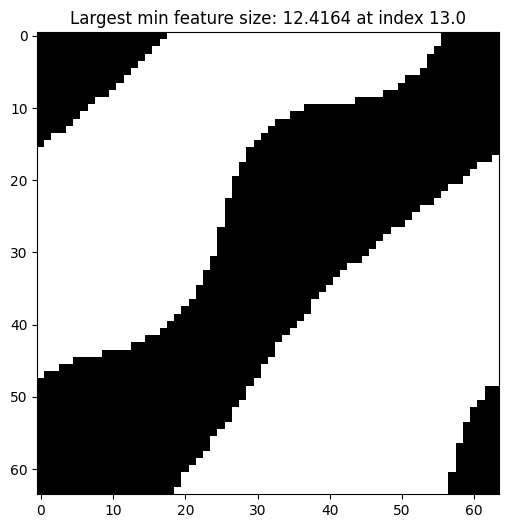

Smallest min feature size: 1.0000 at index 0.0


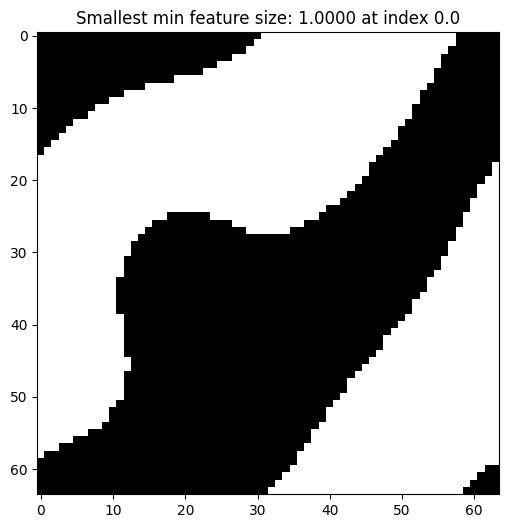

25th percentile: 1.0000
50th percentile (median): 1.0000
75th percentile: 7.0000


In [56]:
if __name__ == '__main__':
    data_cfg = get_data_cfg('c2')
    main(data_cfg)